# IWT Project Visualizations & Analysis

### Setup

In [1]:
%load_ext autoreload
%autoreload 2

%config Completer.use_jedi = False

import os
from pathlib import Path

cwd = Path(os.getcwd())
if cwd.name == "notebooks":
    os.chdir("..")

In [ ]:
# Import Libraries
from functools import cmp_to_key
from collections import Counter
from collections import defaultdict
import cartopy.crs as ccrs  
import geopandas as gpd
from cartopy.feature import BORDERS, COASTLINE
from shapely.geometry import LineString
from adjustText import adjust_text
import pylev
import tqdm.auto as tqdm
import csv
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from scipy.stats import pearsonr
import scipy.stats as stats
import pandas as pd
import networkx as nx
import numpy as np
import torch
import matplotlib.colors as mcolors
import tqdm.auto as tqdm
import torch_geometric as tg
from torch.utils.data import DataLoader
from fuzzywuzzy import process
from methods.data_handling import base_flight_network
from methods import seizure_data, network_data, nx_utils
from methods.filepath_utils import DataPathing
from sklearn.preprocessing import MinMaxScaler
import matplotlib.cm as cm
from bokeh.layouts import gridplot

### Load Networks

#### Full Flight Network

In [3]:
# Read in Network File
import pickle
file_path = os.path.join('./data_cache/seizure_augmented_network.gpickle')
with open(os.path.join(os.getcwd(), file_path), 'rb') as f:
    full = pickle.load(f)

In [4]:
# Calculate Degree, Betweeness, Closeness, and Eigenvector Centrality for the full network
degree_full = nx.degree_centrality(full)
between_full = nx.betweenness_centrality(full)
close_full = nx.closeness_centrality(full)
eigen_full = nx.eigenvector_centrality(full)
pr_full = nx.pagerank(full)
degree_in_full = nx.in_degree_centrality(full)
degree_out_full = nx.out_degree_centrality(full)

# Add the calculated centrality measures to the nodes
nx.set_node_attributes(full, degree_full, 'degree_full')
nx.set_node_attributes(full, between_full, 'between_full')
nx.set_node_attributes(full, close_full, 'close_full')
nx.set_node_attributes(full, eigen_full, 'eigen_full')
nx.set_node_attributes(full, pr_full, 'pr_full')
nx.set_node_attributes(full, degree_in_full, 'degree_in_full')
nx.set_node_attributes(full, degree_out_full, 'degree_out_full')

#### Observed Trafficking Network

In [ ]:
file_path = os.path.join('./data_cache/routes_paths.pkl')
with open(os.path.join(os.getcwd(), file_path), 'rb') as f:
    routes = pickle.load(f)

routes = [tuple(sublist) for sublist in routes if len(sublist) > 1]

incident_counts = Counter([node for path in routes for node in path])

routes2 = []
for tup in routes:
    if len(tup) == 2:
        routes2.append(tup)
    else:
        for i in range(len(tup)-1):         
            routes2.append((tup[i], tup[i + 1]))

In [ ]:
seizure = nx.DiGraph()

# Add nodes and edges to the graph
seizure.add_edges_from(routes2)
seizure_nodes = list(seizure.nodes())

# Retrieve the features attached to the nodes in the full network and add them to the seizure network nodes
seizure_nodes_data = {node: full.nodes[node] for node in seizure_nodes}
for node, data in seizure_nodes_data.items():
    seizure.nodes[node].update(data)

# Add incident counts as feature for nodes in seizure network
for node in seizure.nodes():
    seizure.nodes[node]['incident_counts'] = incident_counts[node]
max_incidents = max(incident_counts.values())
for node in seizure.nodes():
    seizure.nodes[node]['incident_counts_norm'] = incident_counts[node] / max_incidents

# Count the number of trafficking incidents that occur at each edge and store in a dictionary -- used for visualization edge weigh
edge_counts = Counter(routes2)
nx.set_edge_attributes(seizure, edge_counts, 'edge_count')
edge_counts_norm = {}
max_edge_count = max(edge_counts.values())
for edge, count in edge_counts.items():
    edge_counts_norm[edge] = count / max_edge_count

# Calculate the degree, betweenness, closeness, and eigenvector centrality for the seizure network
degree_seizure = nx.degree_centrality(seizure)
between_seizure = nx.betweenness_centrality(seizure)
close_seizure = nx.closeness_centrality(seizure)
eigen_seizure = nx.eigenvector_centrality(seizure)
pr_seizure = nx.pagerank(seizure)
degree_in_seizure = nx.in_degree_centrality(seizure)
degree_out_seizure = nx.out_degree_centrality(seizure)

nx.set_node_attributes(seizure, degree_seizure, 'degree_seizure')
nx.set_node_attributes(seizure, between_seizure, 'between_seizure')
nx.set_node_attributes(seizure, close_seizure, 'close_seizure')
nx.set_node_attributes(seizure, eigen_seizure, 'eigen_seizure')
nx.set_node_attributes(seizure, pr_seizure, 'pr_seizure')
nx.set_node_attributes(seizure, degree_in_seizure, 'degree_in_seizure')
nx.set_node_attributes(seizure, degree_out_seizure, 'degree_out_seizure')

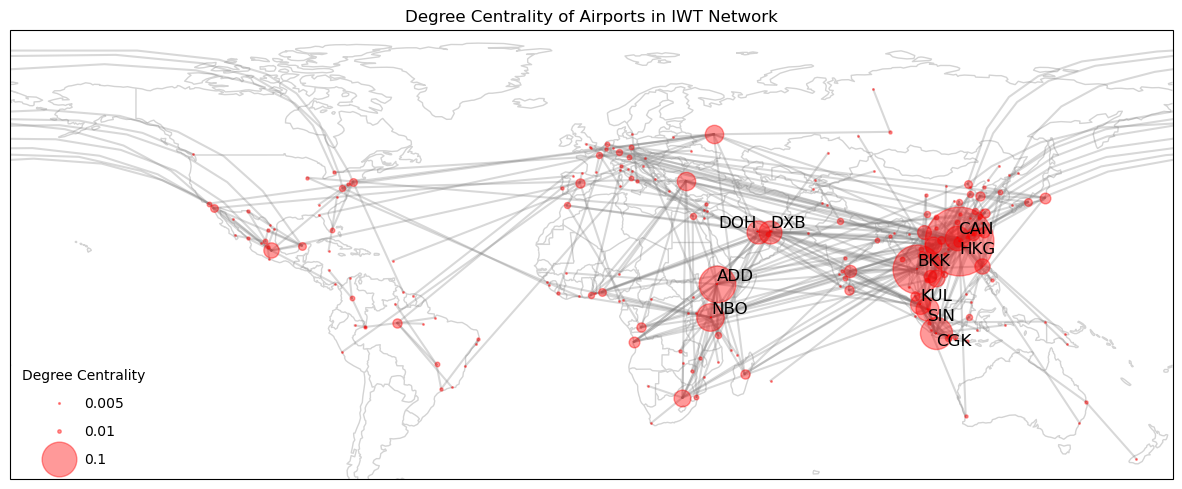

In [ ]:
scaling_factor = 100
fig, ax = plt.subplots(figsize=(15, 12), subplot_kw={'projection': ccrs.PlateCarree()})
ax.add_feature(BORDERS, edgecolor='#d3d3d3')
ax.add_feature(COASTLINE, edgecolor='#d3d3d3')

def plot_geodesic_path(start_lon, start_lat, end_lon, end_lat, alpha):
    ax.plot([start_lon, end_lon], [start_lat, end_lat], color='gray', alpha=alpha, transform=ccrs.Geodetic())

# Plot edges
for edge in seizure.edges():
    start_node = seizure.nodes[edge[0]]
    end_node = seizure.nodes[edge[1]]
    start_lon, start_lat = start_node['longitude'], start_node['latitude']
    end_lon, end_lat = end_node['longitude'], end_node['latitude']
        
    if (start_lon > 100 and end_lon < -60) or (start_lon < -60 and end_lon > 100):
        plot_geodesic_path(start_lon, start_lat, end_lon, end_lat, alpha=0.3)
    else:
        ax.plot([start_lon, end_lon], [start_lat, end_lat], color='gray', alpha=0.3)

for node in seizure.nodes:  
    lon, lat = seizure.nodes[node]['longitude'], seizure.nodes[node]['latitude']
    size = seizure.nodes[node]['degree_seizure'] * 250
    ax.plot(lon, lat, 'ro', markersize=size, alpha=0.4) 

top_nodes = sorted(seizure.nodes(), key=lambda x: seizure.nodes[x]['degree_seizure'], reverse=True)[:10]
labels = [node for node in top_nodes]
texts = [ax.text(seizure.nodes[node]['longitude'], seizure.nodes[node]['latitude'], label, fontsize=12, ha='left', va='bottom', transform=ccrs.PlateCarree()) for node, label in zip(top_nodes, labels)]
adjust_text(texts, expand_text=(1.05, 1.05), expand_points=(1.05, 1.05), arrowprops=dict(arrowstyle='-', color='red'))

sizes = [0.005, 0.01 , 0.1]
for size in sizes:
    ax.plot([], [], 'ro', markersize=size*250, alpha=0.4, label=str(size))
ax.legend(scatterpoints=1, frameon=False, labelspacing=1, loc='lower left', title="Degree Centrality")

ax.set_title("Degree Centrality of Airports in IWT Network")
plt.show()


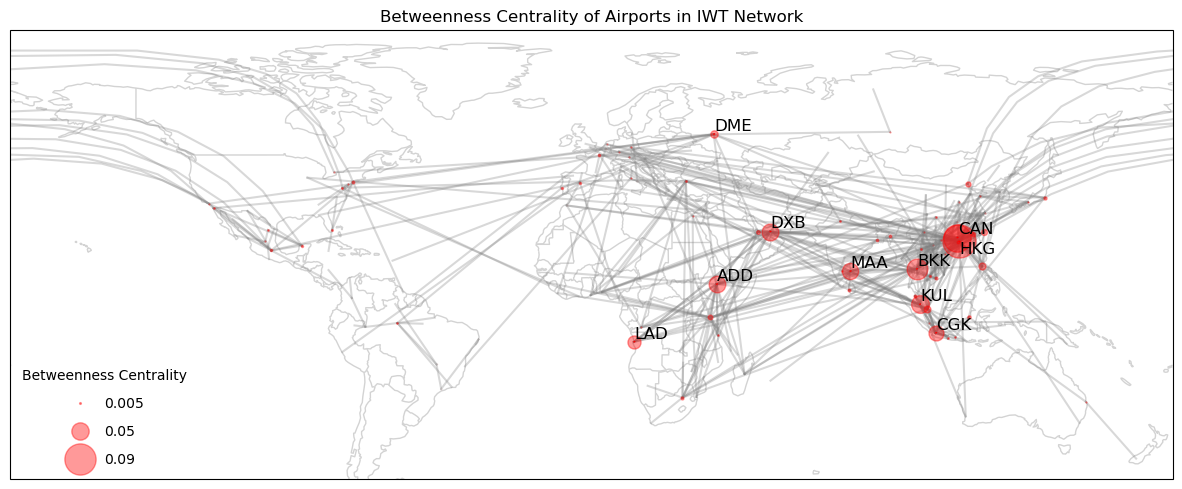

In [ ]:
scaling_factor = 100
fig, ax = plt.subplots(figsize=(15, 12), subplot_kw={'projection': ccrs.PlateCarree()})
ax.add_feature(BORDERS, edgecolor='#d3d3d3')
ax.add_feature(COASTLINE, edgecolor='#d3d3d3')

def plot_geodesic_path(start_lon, start_lat, end_lon, end_lat, alpha):
    ax.plot([start_lon, end_lon], [start_lat, end_lat], color='gray', alpha=alpha, transform=ccrs.Geodetic())

for edge in seizure.edges():
    start_node = seizure.nodes[edge[0]]
    end_node = seizure.nodes[edge[1]]
    start_lon, start_lat = start_node['longitude'], start_node['latitude']
    end_lon, end_lat = end_node['longitude'], end_node['latitude']
        
    if (start_lon > 100 and end_lon < -60) or (start_lon < -60 and end_lon > 100):
        plot_geodesic_path(start_lon, start_lat, end_lon, end_lat, alpha=0.3)
    else:
        ax.plot([start_lon, end_lon], [start_lat, end_lat], color='gray', alpha=0.3)

for node in seizure.nodes:  
    lon, lat = seizure.nodes[node]['longitude'], seizure.nodes[node]['latitude']
    size = seizure.nodes[node]['between_seizure'] * 250
    ax.plot(lon, lat, 'ro', markersize=size, alpha=0.4)  # Red color for top nodes, adjust alpha as needed

# Label the top 10 nodes on the map based on their degree centrality
top_nodes = sorted(seizure.nodes(), key=lambda x: seizure.nodes[x]['between_seizure'], reverse=True)[:10]
labels = [node for node in top_nodes]
texts = [ax.text(seizure.nodes[node]['longitude'], seizure.nodes[node]['latitude'], label, fontsize=12, ha='left', va='bottom', transform=ccrs.PlateCarree()) for node, label in zip(top_nodes, labels)]
adjust_text(texts, expand_text=(1.05, 1.05), expand_points=(1.05, 1.05), arrowprops=dict(arrowstyle='-', color='red'))

sizes = [0.005, 0.05 , 0.09]
for size in sizes:
    ax.plot([], [], 'ro', markersize=size*250, alpha = 0.4, label=str(size))
ax.legend(scatterpoints=1, frameon=False, labelspacing=1, loc='lower left', title="Betweenness Centrality")

ax.set_title("Betweenness Centrality of Airports in IWT Network")
plt.show()

### Network Comparison: Observed IWT Paths vs. Full Flight Network

In [ ]:
seizure_data = {node: data for node, data in seizure.nodes(data=True)}
seizure_df = pd.DataFrame.from_dict(seizure_data, orient='index').reset_index()
seizure_df = seizure_df.rename(columns={'index': 'ID'})

full_data2 = {node: data for node, data in full.nodes(data=True)}
full_df2 = pd.DataFrame.from_dict(full_data2, orient='index').reset_index()
full_df2 = full_df2.rename(columns={'index': 'ID'})

merged_data =pd.merge(seizure_df, full_df2, on=seizure_df.columns.intersection(full_df2.columns).tolist(), how='outer')

# If the values for degree_seizure is NaN, please maked a new column 'in_seizure?' equal to 0 and 1 otherwise
merged_data['in_seizure?'] = np.where(merged_data['degree_seizure'].isnull(), 0, 1)
merged_data.to_csv('merged_data.csv')

In [34]:
merged_data

,ID,id,name,city,country,ICAO,latitude,longitude,altitude,timezone,...,incident_counts,incident_counts_norm,degree_seizure,between_seizure,close_seizure,eigen_seizure,pr_seizure,degree_in_seizure,degree_out_seizure,in_seizure?
0,BNE,3320,Brisbane International Airport,Brisbane,australia,YBBN,-27.384199,153.117004,13,10.0,...,2.0,0.023810,0.008811,0.002398,0.093213,6.189501e-03,0.002374,0.004405,0.004405,1
1,ZQN,2030,Queenstown International Airport,Queenstown International,new zealand,NZQN,-45.021099,168.738998,1171,12.0,...,1.0,0.011905,0.004405,0.000000,0.080734,2.000122e-03,0.003614,0.004405,0.000000,1
2,IMF,3050,Imphal Airport,Imphal,india,VEIM,24.760000,93.896698,2540,5.5,...,2.0,0.023810,0.004405,0.000000,0.000000,2.549365e-16,0.001596,0.000000,0.004405,1
3,DEL,3093,Indira Gandhi International Airport,Delhi,india,VIDP,28.566500,77.103104,777,5.5,...,5.0,0.059524,0.017621,0.004210,0.084495,3.213811e-03,0.003402,0.008811,0.008811,1
4,KBP,2939,Boryspil International Airport,Kiev,ukraine,UKBB,50.345001,30.894699,427,2.0,...,2.0,0.023810,0.004405,0.000000,0.000000,2.549365e-16,0.001596,0.000000,0.004405,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1928,PKE,6317,Parkes Airport,Parkes,australia,YPKS,-33.131401,148.238998,1069,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1929,GFF,6271,Griffith Airport,Griffith,australia,YGTH,-34.250801,146.067001,439,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1930,MIM,6294,Merimbula Airport,Merimbula,australia,YMER,-36.908600,149.901001,7,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1931,MYA,6302,Moruya Airport,Moruya,australia,YMRY,-35.897800,150.143997,14,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


##### Centrality Analysis Plots

In [ ]:
###### FIGURE 3A

centrality_metrics = ['degree', 'between']

subset_columns = [f'{metric}_seizure' for metric in centrality_metrics]
merged_data[subset_columns] = merged_data[subset_columns].fillna(0)

plots = []
for metric in centrality_metrics:
    if metric == 'between':
        title = 'Betweenness Centrality in IWT vs. Full Flight Network per Airport'
    else:
        title = 'Degree Centrality in IWT vs. Full Flight Network per Airport'
    p = figure(title=title, x_axis_label='IWT Network', y_axis_label='Full Flight Network',
               width=600, height=350, x_range=(-0.001, merged_data[f'{metric}_seizure'].max() * 1.2),
               y_range=(-0.001, merged_data[f'{metric}_full'].max() * 1.2))

    p.grid.visible = False
    source = ColumnDataSource(data=dict(
        x=merged_data[f'{metric}_seizure'],
        y=merged_data[f'{metric}_full'],
        color=np.where(merged_data[f'{metric}_seizure'] == 0, 'grey', 'red'),  # Map colors based on IWT Network
        ID=merged_data['ID']
    ))
    p.scatter('x', 'y', source=source, fill_alpha=0.6, line_color=None, size=8, fill_color='color')

    # Add diagonal red line
    p.line([0, merged_data[f'{metric}_full'].max()*1.2], [0, merged_data[f'{metric}_full'].max()*1.2], line_color='blue', line_dash='dashed')

    # Label the top 5 highest values in the seizure network
    top_seizure = merged_data.nlargest(5, f'{metric}_seizure')
    for _, row in top_seizure.iterrows():
        differential = 0.004 if metric == 'degree' else 0.002
        p.add_layout(Arrow(end=NormalHead(size=3, line_width=0.05, line_color='grey'),
                           x_start=row[f'{metric}_seizure'], y_start=row[f'{metric}_full'],
                           x_end=row[f'{metric}_seizure'] + differential, y_end=row[f'{metric}_full'] + differential))
        p.add_layout(Label(x=row[f'{metric}_seizure'] + differential, y=row[f'{metric}_full'] + differential, text=row['ID'], text_font_size='10px'))

    # Label the top 2 in the full flight network
    top_full = merged_data.nlargest(2, f'{metric}_full')
    for _, row in top_full.iterrows():
        if metric == 'degree' and row['ID'] == 'FRA':
            p.add_layout(Arrow(end=NormalHead(size=5, line_width=0.05, line_color='grey'),
                           x_start=row[f'{metric}_seizure'], y_start=row[f'{metric}_full']-.1*differential,
                           x_end=row[f'{metric}_seizure'] + differential, y_end=row[f'{metric}_full']+ .5*differential))
            p.add_layout(Label(x=row[f'{metric}_seizure'] + 1.1*differential, y=row[f'{metric}_full'], text=row['ID'], text_font_size='10px'))

        else: 
            differential = 0.004 if metric == 'degree' else 0.002
            p.add_layout(Arrow(end=NormalHead(size=5, line_width=0.05, line_color='grey'),
                            x_start=row[f'{metric}_seizure'], y_start=row[f'{metric}_full'],
                            x_end=row[f'{metric}_seizure'] + differential, y_end=row[f'{metric}_full'] + differential))
            p.add_layout(Label(x=row[f'{metric}_seizure'] + differential, y=row[f'{metric}_full'] + differential, text=row['ID'], text_font_size='10px'))

    # Label the top 2 in the full flight network and NOT in IWT
    top_full_non_iwt = merged_data[(merged_data[f'{metric}_seizure'] == 0) & (merged_data[f'{metric}_full'] != 0)].nlargest(2, f'{metric}_full')
    for _, row in top_full_non_iwt.iterrows():
        p.add_layout(Arrow(end=NormalHead(size=5, line_width=0.05, line_color='grey'),
                           x_start=row[f'{metric}_seizure'], y_start=row[f'{metric}_full'],
                           x_end=row[f'{metric}_seizure'] + differential, y_end=row[f'{metric}_full'] + differential))
        p.add_layout(Label(x=row[f'{metric}_seizure'] + differential, y=row[f'{metric}_full'] + differential, text=row['ID'], text_font_size='10px'))

    # # Add correlation information
    corr_value = merged_data[[f'{metric}_seizure', f'{metric}_full']].corr().iloc[0, 1]
    # x_coord = 0.05 * (p.x_range.end - p.x_range.start)
    # y_coord = 0.05 * (p.y_range.end - p.y_range.start)
    # p.add_layout(Label(x=x_coord, y=y_coord, x_units='screen', y_units='screen',
                    #    text=f'Correlation: {corr_value:.2f}', text_font_size='10px', text_color='black'))

    plots.append(p)

grid = gridplot([[plots[0], plots[1]]], toolbar_location=None)
show(grid)

In [ ]:
#### FIGURE 3B

centrality_measures = ['degree_full', 'between_full']
num_bins = 10

# Specific bin centers for each centrality measure - calculated using np.linspace
bin_centers_degree = np.array([0.00649586, 0.01845238, 0.0304089, 0.04236542, 0.05432195,
                               0.06627847, 0.07823499, 0.09019151, 0.10214803, 0.11410455])

bin_centers_between = np.array([0.00148543, 0.00445629, 0.00742715, 0.010398, 0.01336886,
                                0.01633972, 0.01931058, 0.02228144, 0.02525229, 0.02822315])

hist_data = {}

# Calculate histograms for each centrality measure
for centrality_measure in centrality_measures:
    merged_data[centrality_measure] = pd.to_numeric(merged_data[centrality_measure], errors='coerce')
        hist_data[centrality_measure], _ = np.histogram(merged_data[centrality_measure], bins=num_bins)

p_degree = figure(title='# Airports in Full Flight Network per Degree Centrality Bin', x_axis_label='Degree Centrality in Full Flight Network', y_axis_label='# Airports', width=600, height=350, y_range=(0, max(hist_data['degree_full']) * 1.1))
p_degree.vbar(x=bin_centers_degree, top=hist_data['degree_full'], width=0.012, color='blue', alpha=0.7)

for x, counts in zip(bin_centers_degree, hist_data['degree_full']):
    p_degree.text(x=x, y=counts + 10, text=[str(counts)], text_align='center', text_font_size='8pt')

p_degree.xaxis.ticker = bin_centers_degree
p_degree.xaxis.major_label_orientation = np.pi / 4  # Rotate labels for better readability

p_between = figure(title='# Airports in Full Flight Network per Betweenness Centrality Bin', x_axis_label='Betweenness Centrality in Full Flight Network', y_axis_label='# Airports', width=600, height=350, y_range=(0, max(hist_data['between_full']) * 1.1))
p_between.vbar(x=bin_centers_between, top=hist_data['between_full'], width=0.003, color='green', alpha=0.7)

for x, counts in zip(bin_centers_between, hist_data['between_full']):
    p_between.text(x=x, y=counts + 10, text=[str(counts)], text_align='center', text_font_size='8pt')

p_between.xaxis.ticker = bin_centers_between
p_between.xaxis.major_label_orientation = np.pi / 4  # Rotate labels for better readability

p_degree.grid.visible = False
p_between.grid.visible = False

grid = gridplot([[p_degree, p_between]], toolbar_location=None)
show(grid)


In [ ]:
### FIGURE 3C

centrality_measures = ['degree_full', 'between_full']
num_bins = 10

# Specific bin centers for each centrality measure
bin_centers_degree = np.array([0.00649586, 0.01845238, 0.0304089, 0.04236542, 0.05432195,
                               0.06627847, 0.07823499, 0.09019151, 0.10214803, 0.11410455])

bin_centers_between = np.array([0.00148543, 0.00445629, 0.00742715, 0.010398, 0.01336886,
                                0.01633972, 0.01931058, 0.02228144, 0.02525229, 0.02822315])

bin_percentages = {}

for centrality_measure in centrality_measures:
    bin_percentages[centrality_measure] = merged_data.groupby(pd.cut(merged_data[centrality_measure], bins=num_bins))[['in_seizure?']].mean().squeeze() * 100

# Create figure for Degree Centrality
p_degree = figure(title='% of Airports in IWT per Degree Centrality Bin', x_axis_label='Degree Centrality in Full Flight Network', y_axis_label='% of Airports in IWT', width=600, height=350, y_range=(0, 110))
p_degree.vbar(x=bin_centers_degree, top=bin_percentages['degree_full'], width=0.012, color='blue', alpha=0.7)

for x, percent in zip(bin_centers_degree, bin_percentages['degree_full']):
    p_degree.text(x=x, y=percent + 1, text=[f'{percent:.0f}%'], text_align='center', text_font_size='8pt')

p_degree.xaxis.ticker = bin_centers_degree
p_degree.xaxis.major_label_orientation = np.pi / 4  # Rotate labels for better readability

# Create figure for Betweenness Centrality
p_between = figure(title='% of Airports in IWT per Betweenness Centrality Bin', x_axis_label='Betweenness Centrality in Full Flight Network', y_axis_label='% of Airports in IWT', width=600, height=350, y_range=(0, 110))
p_between.vbar(x=bin_centers_between, top=bin_percentages['between_full'], width=0.003, color='green', alpha=0.7)

for x, percent in zip(bin_centers_between, bin_percentages['between_full']):
    p_between.text(x=x, y=percent + 1, text=[f'{percent:.0f}%'], text_align='center', text_font_size='8pt')

p_between.xaxis.ticker = bin_centers_between
p_between.xaxis.major_label_orientation = np.pi / 4  # Rotate labels for better readability

p_degree.grid.visible = False
p_between.grid.visible = False
grid = gridplot([[p_degree, p_between]], toolbar_location=None)
show(grid)


/var/folders/px/g1w30xmx4gq5qw1_pnfzn1n40000gn/T/ipykernel_2196/3285891862.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_percentages[centrality_measure] = merged_data.groupby(pd.cut(merged_data[centrality_measure], bins=num_bins))[['in_seizure?']].mean().squeeze() * 100
/var/folders/px/g1w30xmx4gq5qw1_pnfzn1n40000gn/T/ipykernel_2196/3285891862.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_percentages[centrality_measure] = merged_data.groupby(pd.cut(merged_data[centrality_measure], bins=num_bins))[['in_seizure?']].mean().squeeze() * 100


### Airport-Level Observations (Non-Path) Analysis

#### Organize Data

In [ ]:
# Read in Updated ROUTES Data -- THIS DATASET IS NOT AVAILABLE FOR PUBLIC USE. PROCESSED VERSIONS OF IT WILL BE AVAIALBLE UPON PUBLICATION.
compiled_routes = pd.read_excel('Compiled_ROUTES_Data.xlsx', header=1)

In [ ]:
def get_paths_from_routes_file(routes_seizure_file, flight_network):
    
    location_columns = [
        ["OriginCity", "OriginCountry", "OriginRegion"],
        ["TransitCity1", "TransitCountry1", "TransitRegion1"],
        ["TransitCity2", "TransitCountry2", "TransitRegion2"],
        ["TransitCity3", "TransitCountry3", "TransitRegion3"],
        ["TransitCity4", "TransitCountry4", "TransitRegion4"],
        ["DestinationCity", "DestinationCountry", "DestinationRegion"]
        ,['SeizureCity', 'SeizureCountry', 'SeizureRegion']
    ]

    location_dict = {
        'origin': ["OriginCity", "OriginCountry", "OriginRegion"],
        'transit1': ["TransitCity1", "TransitCountry1", "TransitRegion1"],
        'transit2': ["TransitCity2", "TransitCountry2", "TransitRegion2"],
        'transit3': ["TransitCity3", "TransitCountry3", "TransitRegion3"],
        'transit4': ["TransitCity4", "TransitCountry4", "TransitRegion4"],
        'destination': ["DestinationCity", "DestinationCountry", "DestinationRegion"]
        ,'seizure': ['SeizureCity', 'SeizureCountry', 'SeizureRegion']
    }

    country_replacements = {
        "camodia": "cambodia",
        "ivory coast": "cote d'ivoire",
        "drc": "congo (kinshasa)",
        "democratic republic of congo": "congo (kinshasa)",
        "roc": "congo (brazzaville)",
        "congo": "congo (brazzaville)",
        "car": "central african republic",
        "chian": "china",
        "indoensia": "indonesia",
        "indonesia and singapore": "singapore",
        "myanmar": "burma",
        "nigeria / cameroon": "cameroon",
        "oregon": "united states",
        "png": "papua new guinea",
        "reunion island": "reunion",
        "singapore / malaysia": "malaysia",
        "uae": "united arab emirates",
        "uk": "united kingdom",
        "usa": "united states",
        "macau": "china",
    }

    routes_df = pd.read_excel(
        routes_seizure_file, sheet_name="Raw Data", skiprows=1, usecols="B:BK"
    )
    for cols in location_columns:
        for c in cols:
            routes_df[c] = routes_df[c].str.lower().str.strip()
        routes_df[cols[1]] = routes_df[cols[1]].replace(country_replacements)

    node_df = base_flight_network.get_flight_node_df(flight_network)
    node_df["city"] = node_df["city"].str.lower()
    node_df["country"] = node_df["country"].str.lower()

    all_locations = set()
    # create location id from location triples
    # if all 3 are nans, then these don't exist, can prune from path
    # eventually need lookup of location triple -> flight node
    for i, row in routes_df.iterrows():
        #     row[location_columns[0]]
        for cols in location_columns:
            all_locations.add(tuple(row[cols].str.lower().str.strip()))

    # ideally all of these locations exist in the flight network
    # drop where country is nan (the only info here is the continent)
    # 100 locations have nan city
    location_df = pd.DataFrame(all_locations, columns=["city", "country", "region"])

    # for each location find relevant node IATA

    city_replacements = {
        "tengchong": "luxi",
        "ordos": "dongsheng",
        "primorsky krai": "vladivostok",
        "elche": "alicante",
        "pangkal pinang": "palembang",
        "bandung": "jakarta",
        "bengaluru": "bangalore",
        #     "reunion island": "st.-denis",
        #     "macau": "macau"
        # join macau by hand
    }

    country_iata_lookup = {
        "hong kong": "HKG",
        "guyana": "GEO",
        "republic of san marino": "RMI",
        "seychelles": "SEZ",
        "congo (brazzaville)": "BZV"
    }

    city_iata_lookup = {
        "reunion island": "RUN",
        "taipei": "TSA",
        "rawalpindi": "ISB",
        "haidong": "XNN",
        "kerala": "TRV",
        "berlin": "LEJ",
        "samarinda": "BPN",
        "schkeuditz": "LEJ",
        "callao": "LIM",
        "hong kong": "HKG",
        "makassar": "UPG",
        "monclova": "MTY",
        "macau": "MFM",
        "macao": "MFM",
        "pingxiang": "HDG",
        "fiumicino": "FCO",
        "leon": "LEN",
        "haicheng": "AOG",
        "doha": "DOH",
        "garanhuns": "MCZ",
        "seawell": "BGI",
        "sabah": "BKI",
        "lubumbashi": "FBM",
        "chaoshan": "SWA",
        "n'djili": "FIH",
        "medan": "PEN",
        "surakarta": "JOG",
        "astana": "KGF",
        "pekanbaru": "PDG",
        "qianjiang": "WUH",
        "mbandaka": "BGF",
        "wuyishan": "JDZ",
        "papua": "LAE",
        "mayotte": "DZA",
        "chennai": "MAA",
        "kisangani": "KSE",
        "heathrow": "LHR",
        "baiyun": "CAN",
        "khatanga": "NSK",
        "hulunbuir city": "NDG",
        "java": "SRG",
        "sumbawa": "LOP",
        "noi bai": "LEJ",
        "banjarmasin": "BPN",
        "bingcheng": "RMI",
        "sihanoukville": "PQC",
        "eilat": "AQJ",
        "cavite": "MNL",
        "lombok": "LOP",
        "cam rinh": "CXR",
        "luanda": "LAD"
    }

    # iatas = ['vie', 'add', 'dar', 'lhr', 'cmb', 'maa', 'bkk', 'ctu', 'fra',
    #    'tnj', 'cgk', 'hkg', 'dxb', 'yyz', 'han', 'doh', 'jfk', 'mia',
    #    'vte', 'sin', 'jnb', 'lad', 'pek', 'trz', 'kul', 'blr', 'dmk',
    #    'tpe', 'del', 'nbo', 'bgf', 'dla']

    low_scores = []
    iatas = []
    for i, row in location_df.iterrows():
        city = row["city"]
        country = row["country"]
        # If the value in city is in IATAs, return it as the IATA
        # if pd.notna(city) and any(code in city.lower() for code in iatas):
        #     iata = city
        #     print(added)
        if city in city_iata_lookup.keys():
            iata = city_iata_lookup[city]
        elif country in country_iata_lookup.keys():
            iata = country_iata_lookup[country]
        else:
            if city in city_replacements.keys():
                city = city_replacements[city]
            country_node_df = node_df[node_df["country"] == country]
            if pd.isna(city):
                if len(country_node_df) == 1:
                    iata = country_node_df.iloc[0, 0]
                else:
                    iata = pd.NA
            else:
                relevant_cities = country_node_df["city"]
                if len(relevant_cities) == 0:
                    iata = pd.NA
                else:
                    flight_net_city, score, ind = process.extractOne(
                        city, relevant_cities
                    )
                    if score < 80:
                        low_scores.append((city, score, list(relevant_cities)))
                        iata = pd.NA
                    else:
                        iata = node_df.loc[ind, "IATA"]
        iatas.append(iata)

    location_df["iata"] = iatas

    location_triple_to_iata = location_df.set_index(
        ["city", "country", "region"]
    ).to_dict(orient="index")

    # create new columns in routes_df based on the keys in location_dict
    for key in location_dict.keys():
        routes_df[f"{key}_iata"] = pd.NA

    # For each location type, create a new column that is the location (orign, transit1,transit2,transit3,transit4, or destination)_iata' that includes for each row the iata value based on the location.
    for i, row in routes_df.iterrows():
        for key, cols in location_dict.items():
            location_triple = tuple(row[cols])
            if location_triple in location_triple_to_iata.keys():
                iata = location_triple_to_iata[location_triple]["iata"]
                routes_df.at[i, f"{key}_iata"] = iata

    return routes_df 


new_routes_df = get_paths_from_routes_file('Compiled_ROUTES_Data.xlsx',full)


In [ ]:
# Combine all the IATA codes per Incident into one column
new_routes_df['combined'] = new_routes_df[['origin_iata', 'transit1_iata', 'transit2_iata', 'transit3_iata', 'transit4_iata', 'destination_iata'
                                           , 'seizure_iata'
                                           ]].apply(lambda x: ','.join(x.dropna().astype(str)), axis=1)

# Take the set of teh combined column to get unique values
new_routes_df['combined'] = new_routes_df['combined'].apply(lambda x: set(x.split(',')))

# Count unique entries in each row. if combined is empty, return 0
new_routes_df['unique_count'] = new_routes_df['combined'].apply(lambda x: len(x) if x != {''} else 0)


In [ ]:
### Read in Wildlife Trade Portal Data -- THIS RAW DATA IS NOT AVAILABLE FOR PUBLIC USE. PROCESSED VERSIONS OF IT WILL BE AVAIALBLE UPON PUBLICATION.

iata_counts = pd.read_csv('iata_counts.csv')

iata_counts = iata_counts.dropna(subset=['IATA'])       # Remove rows that have no airports in the incident

# return values in iata_counts into a list
iata_counts_list = iata_counts['IATA'].tolist()

# # create a new dataframe that has the IATA code, and the number of times it is present in each of the columns in new_routes_df 
# iata_counts_df = pd.DataFrame(columns=['IATA', 'Origin', 'Transit', 'Seizure', 'Destination'])

#### Origin Counts

In [ ]:
# Count the number of times each city appears in Seizure City
new_routes_df['origin_iata'].value_counts()

# Add the origin counts associated to each node in the full flight network equal to its value count
full_nodes = full.nodes()
for node in full_nodes:
    # if airport present in both older dataset and newer dataset
    if node in new_routes_df['origin_iata'].value_counts() and node in iata_counts_list:
        full.nodes[node]['origin_count'] = (new_routes_df['origin_iata'].value_counts()[node] + iata_counts[iata_counts['IATA'] == node]['Origin Location'].iloc[0])
    # if airport only in older dataset
    elif node in new_routes_df['origin_iata'].value_counts() and node not in iata_counts_list:
        full.nodes[node]['origin_count'] = new_routes_df['origin_iata'].value_counts()[node]
    # if airport only in newer dataset
    elif node not in new_routes_df['origin_iata'].value_counts() and node in iata_counts_list:
        full.nodes[node]['origin_count'] = iata_counts[iata_counts['IATA'] == node]['Origin Location'].iloc[0]
    # if it is in neither, it is not a part of the seizure network in that role
    else:
        full.nodes[node]['origin_count'] = 0

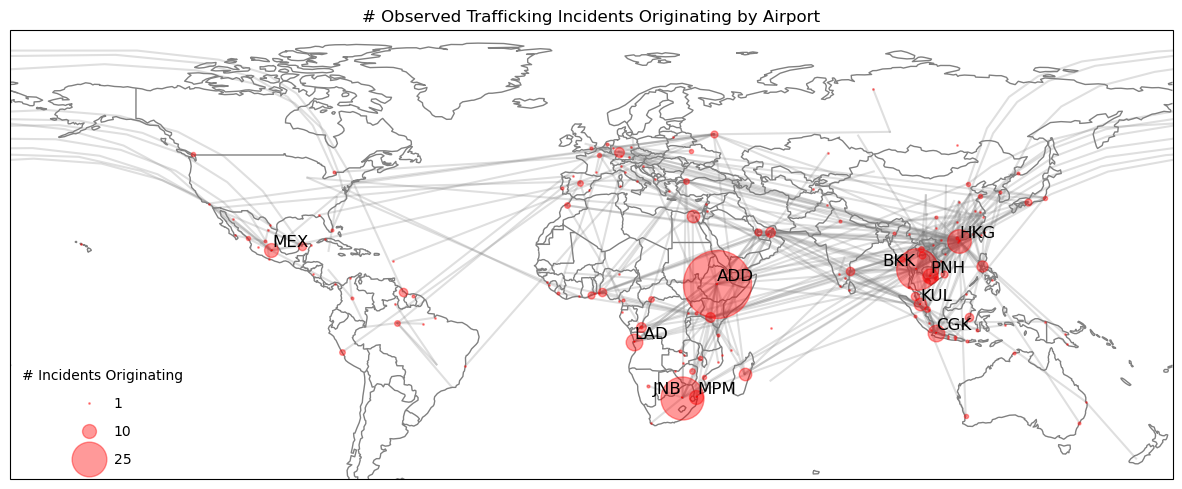

In [ ]:
scaling_factor = 100
fig, ax = plt.subplots(figsize = (15,12),subplot_kw={'projection': ccrs.PlateCarree()})
ax.add_feature(BORDERS, edgecolor='gray')
ax.add_feature(COASTLINE, edgecolor='gray')

def plot_geodesic_path(start_lon, start_lat, end_lon, end_lat, alpha):
    ax.plot([start_lon, end_lon], [start_lat, end_lat], color='gray', alpha=alpha, transform=ccrs.Geodetic())

for edge in seizure.edges():
    if full.nodes[edge[0]]['origin_count'] > 0 or full.nodes[edge[1]]['origin_count'] > 0:
        start_node = seizure.nodes[edge[0]]
        end_node = seizure.nodes[edge[1]]
        start_lon, start_lat = start_node['longitude'], start_node['latitude']
        end_lon, end_lat = end_node['longitude'], end_node['latitude']
        
        if (start_lon > 100 and end_lon < -60) or (start_lon < -60 and end_lon > 100):
            plot_geodesic_path(start_lon, start_lat, end_lon, end_lat, alpha=0.25)
        else:
            ax.plot([start_lon, end_lon], [start_lat, end_lat], color='gray', alpha=0.25)

for node in full.nodes():
    if full.nodes[node]['origin_count'] > 0:
        lon, lat = full.nodes[node]['longitude'], full.nodes[node]['latitude']
        size = full.nodes[node]['origin_count']
        ax.plot(lon, lat, 'ro', markersize=size, alpha=0.4)

top_nodes = sorted(full.nodes(), key=lambda x: full.nodes[x]['origin_count'], reverse=True)[:10]
labels = [node for node in top_nodes]
texts = [ax.text(seizure.nodes[node]['longitude'], seizure.nodes[node]['latitude'], label, fontsize=12, ha='left', va='bottom', transform=ccrs.PlateCarree()) for node, label in zip(top_nodes, labels)]
adjust_text(texts, expand_text=(1.05, 1.05), expand_points=(1.05, 1.05), arrowprops=dict(arrowstyle='-', color='red'))

sizes = [1,10,25]
for size in sizes:
    ax.plot([], [], 'ro', markersize=size, alpha = 0.4, label=str(size))
ax.legend(scatterpoints=1, frameon=False, labelspacing=1, loc='lower left', title="# Incidents Originating")

ax.set_title("# Observed Trafficking Incidents Originating by Airport")
plt.show()

#### Transit Counts

In [42]:
# Count the number of times each city appears in any of the TransityCity columns 1-4
transit_cities = pd.concat([new_routes_df['transit1_iata'], new_routes_df['transit2_iata'], new_routes_df['transit3_iata'], new_routes_df['transit4_iata']], axis=0)
transit_cities.value_counts()

# Add the transit counts associated to each node in the full flight network equal to its value count
full_nodes = full.nodes()
for node in full_nodes:
    if node in transit_cities.value_counts() and node in iata_counts_list:
        full.nodes[node]['transit_count'] = (transit_cities.value_counts()[node] + iata_counts[iata_counts['IATA'] == node]['Transit Location'].iloc[0])
    elif node in transit_cities.value_counts() and node not in iata_counts_list:
        full.nodes[node]['transit_count'] = transit_cities.value_counts()[node]
    elif node not in transit_cities.value_counts() and node in iata_counts_list:
        full.nodes[node]['transit_count'] = iata_counts[iata_counts['IATA'] == node]['Transit Location'].iloc[0]
    else:
        full.nodes[node]['transit_count'] = 0

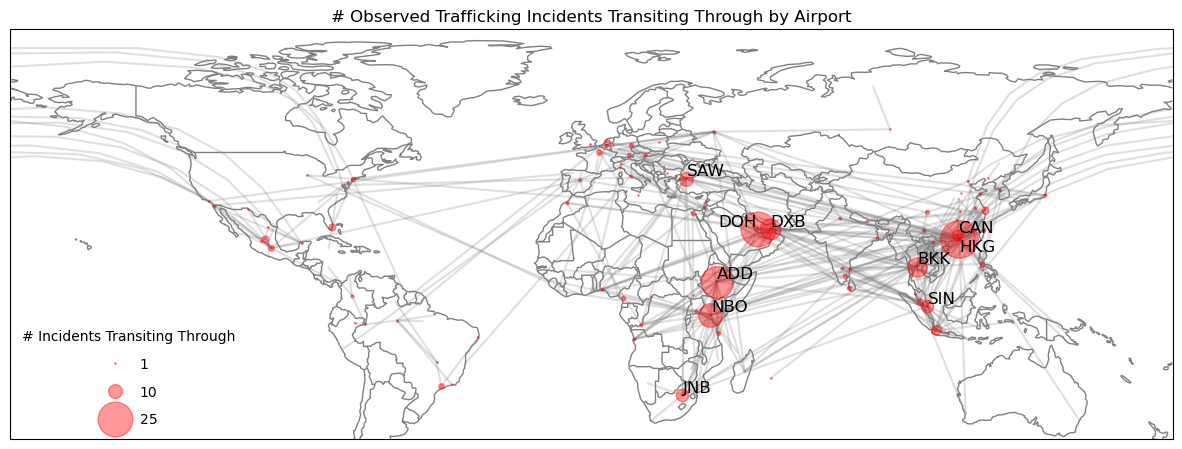

In [ ]:
# Visualize Transit Airports
scaling_factor = 100
fig, ax = plt.subplots(figsize = (15,12),subplot_kw={'projection': ccrs.PlateCarree()})
ax.add_feature(BORDERS, edgecolor='gray')
ax.add_feature(COASTLINE, edgecolor='gray')

def plot_geodesic_path(start_lon, start_lat, end_lon, end_lat, alpha):
    ax.plot([start_lon, end_lon], [start_lat, end_lat], color='gray', alpha=alpha, transform=ccrs.Geodetic())

for edge in seizure.edges():
    if full.nodes[edge[0]]['transit_count'] > 0 or full.nodes[edge[1]]['transit_count'] > 0:
        start_node = seizure.nodes[edge[0]]
        end_node = seizure.nodes[edge[1]]
        start_lon, start_lat = start_node['longitude'], start_node['latitude']
        end_lon, end_lat = end_node['longitude'], end_node['latitude']
        
        if (start_lon > 100 and end_lon < -60) or (start_lon < -60 and end_lon > 100):
            plot_geodesic_path(start_lon, start_lat, end_lon, end_lat, alpha=0.25)
        else:
            ax.plot([start_lon, end_lon], [start_lat, end_lat], color='gray', alpha=0.25)

for node in full.nodes():
    if full.nodes[node]['transit_count'] > 0:
        lon, lat = full.nodes[node]['longitude'], full.nodes[node]['latitude']
        size = full.nodes[node]['transit_count']
        ax.plot(lon, lat, 'ro', markersize=size, alpha=0.4)

top_nodes = sorted(full.nodes(), key=lambda x: full.nodes[x]['transit_count'], reverse=True)[:10]
labels = [node for node in top_nodes]
texts = [ax.text(seizure.nodes[node]['longitude'], seizure.nodes[node]['latitude'], label, fontsize=12, ha='left', va='bottom', transform=ccrs.PlateCarree()) for node, label in zip(top_nodes, labels)]
adjust_text(texts, expand_text=(1.05, 1.05), expand_points=(1.05, 1.05), arrowprops=dict(arrowstyle='-', color='red'))

sizes = [1,10,25]
for size in sizes:
    ax.plot([], [], 'ro', markersize=size, alpha = 0.4, label=str(size))
ax.legend(scatterpoints=1, frameon=False, labelspacing=1, loc='lower left', title="# Incidents Transiting Through")

ax.set_title("# Observed Trafficking Incidents Transiting Through by Airport")
plt.show()

#### Destination Counts

In [24]:
new_routes_df['destination_iata'].value_counts()

# Add the transit counts associated to each node in the full flight network equal to its value count
full_nodes = full.nodes()
for node in full_nodes:
    if node in new_routes_df['destination_iata'].value_counts() and node in iata_counts_list:
        full.nodes[node]['destination_count'] = (new_routes_df['destination_iata'].value_counts()[node] + iata_counts[iata_counts['IATA'] == node]['Destination Location'].iloc[0])
    elif node in new_routes_df['destination_iata'].value_counts() and node not in iata_counts_list:
        full.nodes[node]['destination_count'] = new_routes_df['destination_iata'].value_counts()[node]
    elif node not in new_routes_df['destination_iata'].value_counts() and node in iata_counts_list:
        full.nodes[node]['destination_count'] = iata_counts[iata_counts['IATA'] == node]['Destination Location'].iloc[0]
    else:
        full.nodes[node]['destination_count'] = 0

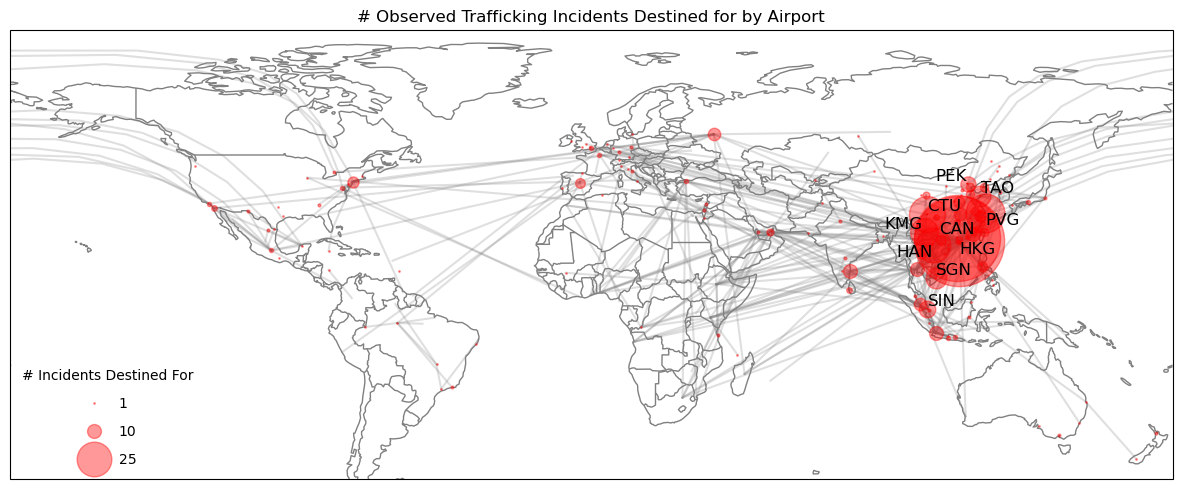

In [25]:
# Visualize Destination Airports
scaling_factor = 100
fig, ax = plt.subplots(figsize = (15,12),subplot_kw={'projection': ccrs.PlateCarree()})
ax.add_feature(BORDERS, edgecolor='gray')
ax.add_feature(COASTLINE, edgecolor='gray')

# Define a function to plot the geodesic path for Asia to North America flights
def plot_geodesic_path(start_lon, start_lat, end_lon, end_lat, alpha):
    ax.plot([start_lon, end_lon], [start_lat, end_lat], color='gray', alpha=alpha, transform=ccrs.Geodetic())

# Only plot edges that are present coming from nodes with a non-zero origin_count
for edge in seizure.edges():
    if full.nodes[edge[0]]['destination_count'] > 0 or full.nodes[edge[1]]['destination_count'] > 0:
        start_node = seizure.nodes[edge[0]]
        end_node = seizure.nodes[edge[1]]
        start_lon, start_lat = start_node['longitude'], start_node['latitude']
        end_lon, end_lat = end_node['longitude'], end_node['latitude']
        
        # Check if the flight is between Asia and North America
        if (start_lon > 100 and end_lon < -60) or (start_lon < -60 and end_lon > 100):
            plot_geodesic_path(start_lon, start_lat, end_lon, end_lat, alpha=0.25)
        else:
            ax.plot([start_lon, end_lon], [start_lat, end_lat], color='gray', alpha=0.25)

# Loop through full.nodes() and plot any node with an observed_count > 0 with a size correspoinding to observed_count
for node in full.nodes():
    if full.nodes[node]['destination_count'] > 0:
        lon, lat = full.nodes[node]['longitude'], full.nodes[node]['latitude']
        size = full.nodes[node]['destination_count']
        ax.plot(lon, lat, 'ro', markersize=size, alpha=0.4)

# Label the top 10 nodes on the map based on their observed_count
top_nodes = sorted(full.nodes(), key=lambda x: full.nodes[x]['destination_count'], reverse=True)[:10]
labels = [node for node in top_nodes]
texts = [ax.text(seizure.nodes[node]['longitude'], seizure.nodes[node]['latitude'], label, fontsize=12, ha='left', va='bottom', transform=ccrs.PlateCarree()) for node, label in zip(top_nodes, labels)]
adjust_text(texts, expand_text=(1.05, 1.05), expand_points=(1.05, 1.05), arrowprops=dict(arrowstyle='-', color='red'))

# Add size legend with name "# Trafficking Incidents Originating"
sizes = [1,10,25]
for size in sizes:
    ax.plot([], [], 'ro', markersize=size, alpha = 0.4, label=str(size))
ax.legend(scatterpoints=1, frameon=False, labelspacing=1, loc='lower left', title="# Incidents Destined For")

# Set title
ax.set_title("# Observed Trafficking Incidents Destined for by Airport")

# Show map
plt.show()

#### Seizure Counts

In [26]:
new_routes_df['seizure_iata'].value_counts()

# Add the seizure counts associated to each node in the full flight network equal to its value count
full_nodes = full.nodes()
for node in full_nodes:
    if node in new_routes_df['seizure_iata'].value_counts() and node in iata_counts_list:
        full.nodes[node]['seizure_count'] = (new_routes_df['seizure_iata'].value_counts()[node] + iata_counts[iata_counts['IATA'] == node]['Discovery Location'].iloc[0])
    elif node in new_routes_df['seizure_iata'].value_counts() and node not in iata_counts_list:
        full.nodes[node]['seizure_count'] = new_routes_df['seizure_iata'].value_counts()[node]
    elif node not in new_routes_df['seizure_iata'].value_counts() and node in iata_counts_list:
        full.nodes[node]['seizure_count'] = iata_counts[iata_counts['IATA'] == node]['Discovery Location'].iloc[0]
    else:
        full.nodes[node]['seizure_count'] = 0

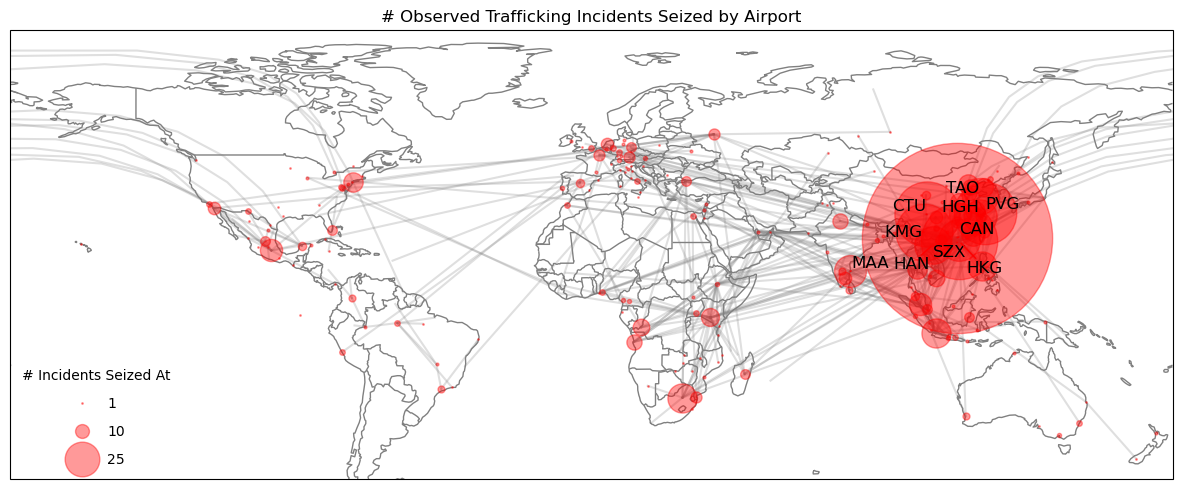

In [ ]:
scaling_factor = 100
fig, ax = plt.subplots(figsize = (15,12),subplot_kw={'projection': ccrs.PlateCarree()})
ax.add_feature(BORDERS, edgecolor='gray')
ax.add_feature(COASTLINE, edgecolor='gray')

def plot_geodesic_path(start_lon, start_lat, end_lon, end_lat, alpha):
    ax.plot([start_lon, end_lon], [start_lat, end_lat], color='gray', alpha=alpha, transform=ccrs.Geodetic())

for edge in seizure.edges():
    if full.nodes[edge[0]]['seizure_count'] > 0 or full.nodes[edge[1]]['seizure_count'] > 0:
        start_node = seizure.nodes[edge[0]]
        end_node = seizure.nodes[edge[1]]
        start_lon, start_lat = start_node['longitude'], start_node['latitude']
        end_lon, end_lat = end_node['longitude'], end_node['latitude']
        
        if (start_lon > 100 and end_lon < -60) or (start_lon < -60 and end_lon > 100):
            plot_geodesic_path(start_lon, start_lat, end_lon, end_lat, alpha=0.25)
        else:
            ax.plot([start_lon, end_lon], [start_lat, end_lat], color='gray', alpha=0.25)

for node in full.nodes():
    if full.nodes[node]['seizure_count'] > 0:
        lon, lat = full.nodes[node]['longitude'], full.nodes[node]['latitude']
        size = full.nodes[node]['seizure_count']
        ax.plot(lon, lat, 'ro', markersize=size, alpha=0.4)

top_nodes = sorted(full.nodes(), key=lambda x: full.nodes[x]['seizure_count'], reverse=True)[:10]
labels = [node for node in top_nodes]
texts = [ax.text(seizure.nodes[node]['longitude'], seizure.nodes[node]['latitude'], label, fontsize=12, ha='left', va='bottom', transform=ccrs.PlateCarree()) for node, label in zip(top_nodes, labels)]
adjust_text(texts, expand_text=(1.05, 1.05), expand_points=(1.05, 1.05), arrowprops=dict(arrowstyle='-', color='red'))

sizes = [1,10,25]
for size in sizes:
    ax.plot([], [], 'ro', markersize=size, alpha = 0.4, label=str(size))
ax.legend(scatterpoints=1, frameon=False, labelspacing=1, loc='lower left', title="# Incidents Seized At")

ax.set_title("# Observed Trafficking Incidents Seized by Airport")
plt.show()

#### Overall Counts

In [ ]:
# Create a count for each node in full_nodes that counts the number of rows it appears in. If 'CAN' is listed twice in one row, only count it once.

# # For each row in new_routes_df, return the unique IATAs in the IATA columns
# unique_iatas = new_routes_df[['origin_iata', 'transit1_iata', 'transit2_iata', 'transit3_iata', 'transit4_iata', 'destination_iata'
#                               , 'seizure_iata'
#                               ]].apply(lambda x: x.unique(), axis=1)
# unique_iatas = unique_iatas.apply(lambda x: [i for i in x if i is not None])

# # Loop through unique_iatas, create a running sum of how mnay times each iata is mentioned
# iata_count = {}
# for iata_list in unique_iatas:
#     for iata in iata_list:
#         if iata in iata_count:
#             iata_count[iata] += 1
#         else:
#             iata_count[iata] = 1

iata_count = {}
for i, row in new_routes_df.iterrows():
    for iata in row['combined']:
        if iata in iata_count:
            iata_count[iata] += 1
        else:
            iata_count[iata] = 1

full_nodes = full.nodes()
for node in full_nodes:
    if node in iata_count and node in iata_counts_list:
        full.nodes[node]['incident_counts'] = iata_count[node] + iata_counts[iata_counts['IATA'] == node]['Report ID'].iloc[0]
    elif node in iata_count and node not in iata_counts_list:
        full.nodes[node]['incident_counts'] = iata_count[node]
    elif node not in iata_count and node in iata_counts_list:
        full.nodes[node]['incident_counts'] = iata_counts[iata_counts['IATA'] == node]['Report ID'].iloc[0]
    else:
        full.nodes[node]['incident_counts'] = 0

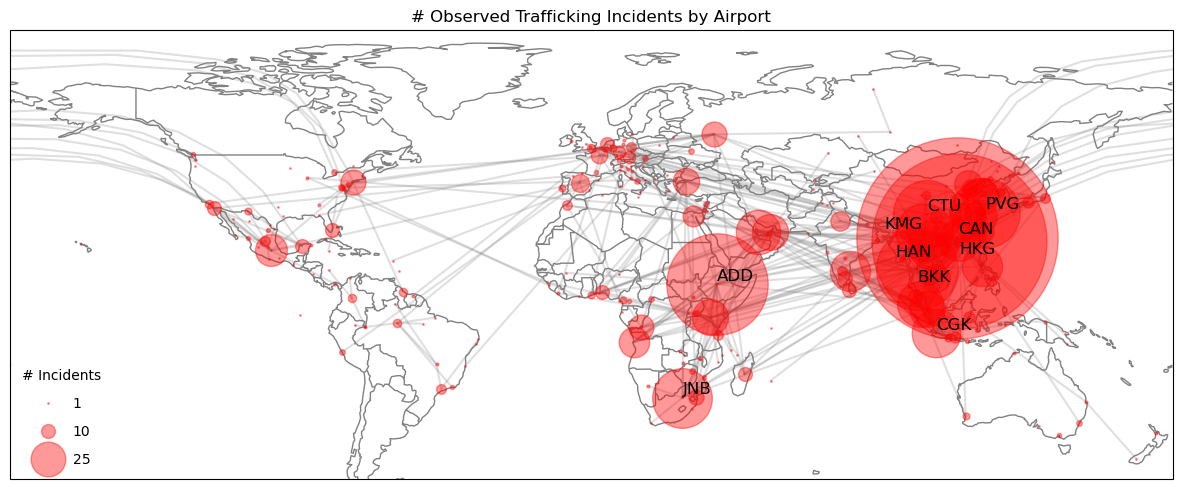

In [ ]:
scaling_factor = 100
fig, ax = plt.subplots(figsize = (15,12),subplot_kw={'projection': ccrs.PlateCarree()})
ax.add_feature(BORDERS, edgecolor='gray')
ax.add_feature(COASTLINE, edgecolor='gray')

def plot_geodesic_path(start_lon, start_lat, end_lon, end_lat, alpha):
    ax.plot([start_lon, end_lon], [start_lat, end_lat], color='gray', alpha=alpha, transform=ccrs.Geodetic())

for edge in seizure.edges():
    if full.nodes[edge[0]]['incident_counts'] > 0 or full.nodes[edge[1]]['incident_counts'] > 0:
        start_node = seizure.nodes[edge[0]]
        end_node = seizure.nodes[edge[1]]
        start_lon, start_lat = start_node['longitude'], start_node['latitude']
        end_lon, end_lat = end_node['longitude'], end_node['latitude']
        
        if (start_lon > 100 and end_lon < -60) or (start_lon < -60 and end_lon > 100):
            plot_geodesic_path(start_lon, start_lat, end_lon, end_lat, alpha=0.25)
        else:
            ax.plot([start_lon, end_lon], [start_lat, end_lat], color='gray', alpha=0.25)

for node in full.nodes():
    if full.nodes[node]['incident_counts'] > 0:
        lon, lat = full.nodes[node]['longitude'], full.nodes[node]['latitude']
        size = full.nodes[node]['incident_counts']
        ax.plot(lon, lat, 'ro', markersize=size, alpha=0.4)

top_nodes = sorted(full.nodes(), key=lambda x: full.nodes[x]['incident_counts'], reverse=True)[:10]
labels = [node for node in top_nodes]
texts = [ax.text(seizure.nodes[node]['longitude'], seizure.nodes[node]['latitude'], label, fontsize=12, ha='left', va='bottom', transform=ccrs.PlateCarree()) for node, label in zip(top_nodes, labels)]
adjust_text(texts, expand_text=(1.05, 1.05), expand_points=(1.05, 1.05), arrowprops=dict(arrowstyle='-', color='red'))

sizes = [1,10,25]
for size in sizes:
    ax.plot([], [], 'ro', markersize=size, alpha = 0.4, label=str(size))
ax.legend(scatterpoints=1, frameon=False, labelspacing=1, loc='lower left', title="# Incidents")

ax.set_title("# Observed Trafficking Incidents by Airport")
plt.show()

### National-Level Data Analysis

In [ ]:
data = []

nodes_with_incidents = {node: data for node, data in full.nodes(data=True) if data.get('incident_counts', 0) > 0}
nodes_with_incidents 

# Iterate over the nodes in the seizure network and extract the country, degree, betweenness, degree_in, degree_out, and observed_count
for node in nodes_with_incidents: 
    country = full.nodes[node]['country']
    observed_count = full.nodes[node]['incident_counts']
    origin_count = full.nodes[node]['origin_count']
    transit_count = full.nodes[node]['transit_count']
    destination_count = full.nodes[node]['destination_count']
    seizure_count = full.nodes[node]['seizure_count']
    if node in seizure.nodes:
        degree_seizure = seizure.nodes[node]['degree_seizure']
        between_seizure = seizure.nodes[node]['between_seizure']
    data.append({'Country': country, 'Node': node, 'Degree': degree_seizure, 'Betweenness': between_seizure, 'Incident_count': observed_count, 'Origin_count': origin_count, 'Transit_count': transit_count, 'Destination_count': destination_count, 'Seizure_count': seizure_count})

airport_df = pd.DataFrame(data)
airport_df = airport_df.sort_values(by=['Country', 'Degree'], ascending=[True, False])
airport_df['Country'] = airport_df['Country'].str.title()

airport_df

,Country,Node,Degree,Betweenness,Incident_count,Origin_count,Transit_count,Destination_count,Seizure_count
202,Albania,TIA,0.004405,0.000000,1,1.0,0.0,0.0,0.0
133,Algeria,ALG,0.004405,0.000000,1,0.0,0.0,1.0,0.0
223,Angola,LAD,0.030837,0.037794,22,12.0,2.0,0.0,11.0
32,Australia,DRW,0.066079,0.019689,2,2.0,0.0,0.0,2.0
41,Australia,PER,0.008811,0.000000,5,3.0,0.0,0.0,5.0
...,...,...,...,...,...,...,...,...,...
275,Vietnam,DAD,0.004405,0.000000,1,1.0,0.0,0.0,0.0
251,Zambia,LVI,0.008811,0.000000,1,1.0,0.0,0.0,1.0
249,Zambia,LUN,0.004405,0.000000,2,1.0,0.0,0.0,1.0
288,Zambia,NLA,0.004405,0.000000,1,1.0,0.0,0.0,1.0


In [211]:
# Use UN to Group Countries into Regions, Subregions, and Continents
subregional_mapping = {
    'Congo (Brazzaville)': 'Sub-Saharan Africa',
    'Barbados': 'Latin America & Caribbean',
    'Hong Kong': 'East Asia',
    'Ethiopia': 'Sub-Saharan Africa',
    'Qatar': 'West Asia',
    'Kenya': 'Sub-Saharan Africa',
    'United Arab Emirates': 'West Asia',
    'Turkey': 'West Asia',
    'South Africa': 'Sub-Saharan Africa',
    'Singapore': 'South-East Asia',
    'Indonesia': 'South-East Asia',
    'Thailand': 'South-East Asia',
    'Mexico': 'Latin America & Caribbean',
    'Netherlands': 'Western Europe',
    'France': 'Western Europe',
    'Malaysia': 'South-East Asia',
    'Germany': 'Western Europe',
    'Sri Lanka': 'South Asia',
    'Spain': 'Western Europe',
    'China': 'East Asia',
    'Congo (Kinshasa)': 'Sub-Saharan Africa',
    'Macau': 'East Asia',
    'Italy': 'Western Europe',
    'Japan': 'East Asia',
    'India': 'South Asia',
    'United States': 'Others',
    'Belgium': 'Western Europe',
    'South Korea': 'East Asia',
    'Russia': 'Eastern Europe',
    'Morocco': 'Sub-Saharan Africa',
    'Lebanon': 'West Asia',
    'Bulgaria': 'Eastern Europe',
    'Brazil': 'Latin America & Caribbean',
    'United Kingdom': 'Western Europe',
    'Reunion': 'Sub-Saharan Africa',
    'Nepal': 'South Asia',
    'South Sudan': 'Sub-Saharan Africa',
    'Vietnam': 'South-East Asia',
    'Colombia': 'Latin America & Caribbean',
    'Egypt': 'Sub-Saharan Africa',
    'Philippines': 'South-East Asia',
    'Taiwan': 'East Asia',
    'Angola': 'Sub-Saharan Africa',
    'Peru': 'Latin America & Caribbean',
    'Tanzania': 'Sub-Saharan Africa',
    'Cameroon': 'Sub-Saharan Africa',
    'Austria': 'Western Europe',
    'Cambodia': 'South-East Asia',
    'Mozambique': 'Sub-Saharan Africa',
    'Madagascar': 'Sub-Saharan Africa',
    'Nigeria': 'Sub-Saharan Africa',
    'Ecuador': 'Latin America & Caribbean',
    'Guyana': 'Latin America & Caribbean',
    'Ghana': 'Sub-Saharan Africa',
    'Laos': 'South-East Asia',
    'Zimbabwe': 'Sub-Saharan Africa',
    'Burma': 'South-East Asia',
    'Canada': 'Others',
    'Central African Republic': 'Sub-Saharan Africa',
    'Malawi': 'Sub-Saharan Africa',
    'Australia': 'Others',
    'Ukraine': 'Eastern Europe',
    'Liberia': 'Sub-Saharan Africa',
    'Portugal': 'Western Europe',
    'Uganda': 'Sub-Saharan Africa',
    'Suriname': 'Latin America & Caribbean',
    'Namibia': 'Sub-Saharan Africa',
    'Zambia': 'Sub-Saharan Africa',
    "Cote D'Ivoire": 'Sub-Saharan Africa',
    'Togo': 'Sub-Saharan Africa',
    'Sierra Leone': 'Sub-Saharan Africa',
    'Comoros': 'Sub-Saharan Africa',
    'Albania': 'Eastern Europe',
    'Jordan': 'West Asia',
    'Kazakhstan': 'West Asia',
    'Equatorial Guinea': 'Sub-Saharan Africa',
    'Greece': 'Western Europe',
    'Gabon': 'Sub-Saharan Africa',
    'Pakistan': 'South Asia',
    'Croatia': 'Eastern Europe',
    'Cuba': 'Latin America & Caribbean',
    'Seychelles': 'Sub-Saharan Africa',
    'Benin': 'Sub-Saharan Africa',
    'Guadeloupe': 'Latin America & Caribbean',
    'Guinea': 'Sub-Saharan Africa',
    'Panama': 'Latin America & Caribbean',
    'Papua New Guinea': 'Others',
    'Tajikistan': 'West Asia',
    'Lithuania': 'Eastern Europe',
    'New Zealand': 'Others',
    'Israel': 'West Asia',
    'Denmark': 'Western Europe',
    'Mayotte': 'Sub-Saharan Africa',
    'Cayman Islands': 'Latin America & Caribbean',
    'Mali': 'Sub-Saharan Africa',
    'Uzbekistan': 'West Asia',
    'Ireland': 'Western Europe',
    'Switzerland': 'Western Europe',
    'Algeria': 'Sub-Saharan Africa',
    'Bangladesh': 'South Asia',
    'Poland': 'Western Europe',
    'Malta': 'Others',
    'Nicaragua': 'Latin America & Caribbean'
}

country_continent_mapping = {
    'Congo (Brazzaville)':'Africa',
    'Barbados': 'Americas',
    'Ecuador': 'Americas',
    'Hong Kong': 'Asia',
    'Ethiopia': 'Africa',
    'Qatar': 'Asia',
    'Kenya': 'Africa',
    'United Arab Emirates': 'Asia',
    'Turkey': 'Asia',
    'South Africa': 'Africa',
    'Singapore': 'Asia',
    'Indonesia': 'Asia',
    'Thailand': 'Asia',
    'Mexico': 'Americas',
    'Netherlands': 'Europe',
    'France': 'Europe',
    'Malaysia': 'Asia',
    'Germany': 'Europe',
    'Sri Lanka': 'Asia',
    'Spain': 'Europe',
    'China': 'Asia',
    'Congo (Kinshasa)': 'Africa',
    'Macau': 'Asia',
    'Italy': 'Europe',
    'Japan': 'Asia',
    'India': 'Asia',
    'United States': 'Americas',
    'Belgium': 'Europe',
    'South Korea': 'Asia',
    'Russia': 'Europe',
    'Morocco': 'Africa',
    'Lebanon': 'Asia',
    'Bulgaria': 'Europe',
    'Brazil': 'Americas',
    'United Kingdom': 'Europe',
    'Reunion': 'Africa',
    'Nepal': 'Asia',
    'South Sudan': 'Africa',
    'Vietnam': 'Asia',
    'Colombia': 'Americas',
    'Egypt': 'Africa',
    'Philippines': 'Asia',
    'Taiwan': 'Asia',
    'Angola': 'Africa',
    'Peru': 'Americas',
    'Tanzania': 'Africa',
    'Cameroon': 'Africa',
    'Austria': 'Europe',
    'Cambodia': 'Asia',
    'Mozambique': 'Africa',
    'Madagascar': 'Africa',
    'Nigeria': 'Africa',
    'Guyana': 'Americas',
    'Ghana': 'Africa',
    'Laos': 'Asia',
    'Zimbabwe': 'Africa',
    'Burma': 'Asia',
    'Canada': 'Americas',
    'Central African Republic': 'Africa',
    'Malawi': 'Africa',
    'Australia': 'Oceania',
    'Ukraine': 'Europe',
    'Liberia': 'Africa',
    'Portugal': 'Europe',
    'Uganda': 'Africa',
    'Suriname': 'Americas',
    'Namibia': 'Africa',
    'Zambia': 'Africa',
    "Cote D'Ivoire": 'Africa',
    'Togo': 'Africa',
    'Sierra Leone': 'Africa',
    'Comoros': 'Africa',
    'Albania': 'Europe',
    'Jordan': 'Asia',
    'Kazakhstan': 'Asia',
    'Equatorial Guinea': 'Africa',
    'Greece': 'Europe',
    'Gabon': 'Africa',
    'Pakistan': 'Asia',
    'Croatia': 'Europe',
    'Cuba': 'Americas',
    'Seychelles': 'Africa',
    'Benin': 'Africa',
    'Guadeloupe': 'Americas',
    'Guinea': 'Africa',
    'Panama': 'Americas',
    'Papua New Guinea': 'Oceania',
    'Tajikistan': 'Asia',
    'Lithuania': 'Europe',
    'New Zealand': 'Oceania',
    'Israel': 'Asia',
    'Denmark': 'Europe',
    'Mayotte': 'Africa',
    'Cayman Islands': 'Americas',
    'Mali': 'Africa',
    'Uzbekistan': 'Asia',
    'Ireland': 'Europe',
    'Switzerland': 'Europe',
    'Algeria': 'Africa',
    'Bangladesh': 'Asia',
    'Poland': 'Europe',
    'Malta': 'Europe',
    'Nicaragua': 'Americas'
}

airport_df['Continent'] = airport_df['Country'].map(country_continent_mapping)
airport_df['Subregion'] = airport_df['Country'].map(subregional_mapping)

airport_df

,Country,Node,Degree,Betweenness,Incident_count,Origin_count,Transit_count,Destination_count,Seizure_count,Path_Total_Count,Origin_Percentage,Transit_Percentage,Destination_Percentage,Continent,Subregion
202,Albania,TIA,0.004405,0.000000,1,1.0,0.0,0.0,0.0,1.0,1.000000,0.000000,0.0,Europe,Eastern Europe
133,Algeria,ALG,0.004405,0.000000,1,0.0,0.0,1.0,0.0,1.0,0.000000,0.000000,1.0,Africa,Sub-Saharan Africa
223,Angola,LAD,0.030837,0.037794,22,12.0,2.0,0.0,11.0,14.0,0.857143,0.142857,0.0,Africa,Sub-Saharan Africa
32,Australia,DRW,0.066079,0.019689,2,2.0,0.0,0.0,2.0,2.0,1.000000,0.000000,0.0,Oceania,Others
41,Australia,PER,0.008811,0.000000,5,3.0,0.0,0.0,5.0,3.0,1.000000,0.000000,0.0,Oceania,Others
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,Vietnam,DAD,0.004405,0.000000,1,1.0,0.0,0.0,0.0,1.0,1.000000,0.000000,0.0,Asia,South-East Asia
251,Zambia,LVI,0.008811,0.000000,1,1.0,0.0,0.0,1.0,1.0,1.000000,0.000000,0.0,Africa,Sub-Saharan Africa
249,Zambia,LUN,0.004405,0.000000,2,1.0,0.0,0.0,1.0,1.0,1.000000,0.000000,0.0,Africa,Sub-Saharan Africa
288,Zambia,NLA,0.004405,0.000000,1,1.0,0.0,0.0,1.0,1.0,1.000000,0.000000,0.0,Africa,Sub-Saharan Africa


In [176]:
# Apply Country Mappings to be loaded into map
custom_mappings = {
    'Burma': 'Myanmar',
    'Congo (Brazzaville)': 'Congo',
    "Cote D'Ivoire": "Côte d'Ivoire",
    'Central African Republic': 'Central African Rep.',
    'Congo (Kinshasa)': 'Dem. Rep. Congo',
    'Equatorial Guinea': 'Eq. Guinea',
    # 'Hong Kong': 'China',
    # 'Macau': 'China',
    'South Sudan': 'S. Sudan',
    'United States': 'United States of America',
}

# Apply the custom mapping to create a new column in country_df
airport_df['Country'] = airport_df['Country'].apply(lambda x: custom_mappings.get(x, x))
airport_df

,Country,Node,Degree,Betweenness,Incident_count,Origin_count,Transit_count,Destination_count,Seizure_count
202,Albania,TIA,0.004405,0.000000,1,1.0,0.0,0.0,0.0
133,Algeria,ALG,0.004405,0.000000,1,0.0,0.0,1.0,0.0
223,Angola,LAD,0.030837,0.037794,22,12.0,2.0,0.0,11.0
32,Australia,DRW,0.066079,0.019689,2,2.0,0.0,0.0,2.0
41,Australia,PER,0.008811,0.000000,5,3.0,0.0,0.0,5.0
...,...,...,...,...,...,...,...,...,...
275,Vietnam,DAD,0.004405,0.000000,1,1.0,0.0,0.0,0.0
251,Zambia,LVI,0.008811,0.000000,1,1.0,0.0,0.0,1.0
249,Zambia,LUN,0.004405,0.000000,2,1.0,0.0,0.0,1.0
288,Zambia,NLA,0.004405,0.000000,1,1.0,0.0,0.0,1.0


### Correlation Analysis

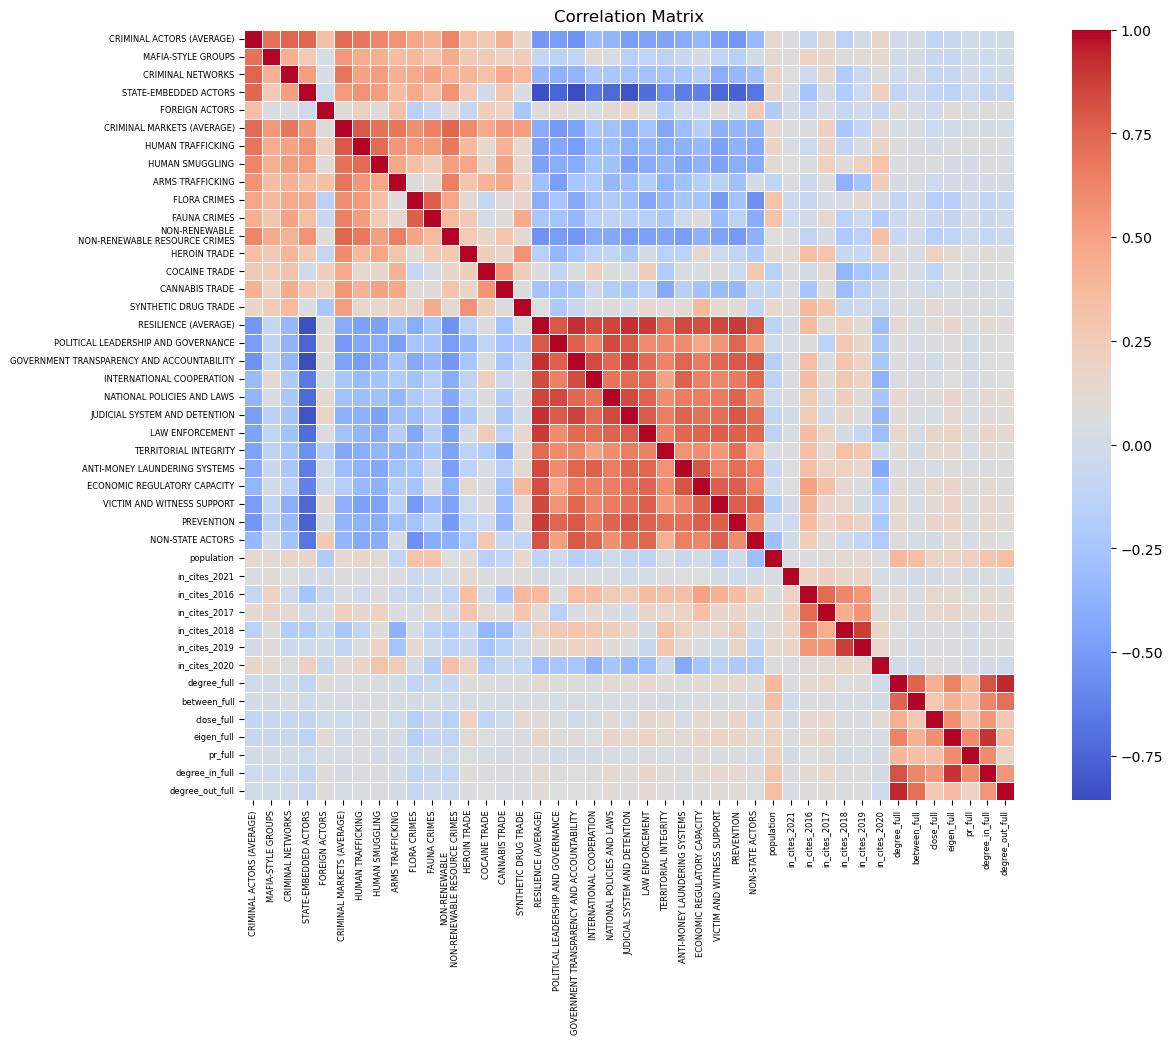

In [ ]:
correlation_matrix_airport = node_df.iloc[:, 14:].corr()

# Set up the heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix_airport, annot=False, cmap='coolwarm', cbar=True, square=True, linewidths=0.5)

plt.xticks(fontsize=6)
plt.yticks(fontsize=6)

plt.title('Correlation Matrix', fontsize=12)
plt.show()

In [ ]:
# Compute correlation of each feature with the target variable 'seizure_count'
target_correlation = node_df.iloc[:, 14:].corrwith(node_df['seizure_count'])

# Sort the correlations in descending order
target_correlation = target_correlation.abs().sort_values(ascending=True)

# Plot the correlations
plt.figure(figsize=(16, 16))
sns.barplot(x=target_correlation.values, y=target_correlation.index, palette='coolwarm')
plt.xlabel('Absolute Correlation')
plt.ylabel('Features')
plt.title("Correlation of Features with 'seizure_count'")
plt.show()

/opt/anaconda3/envs/iwt_path_pred/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/envs/iwt_path_pred/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/envs/iwt_path_pred/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


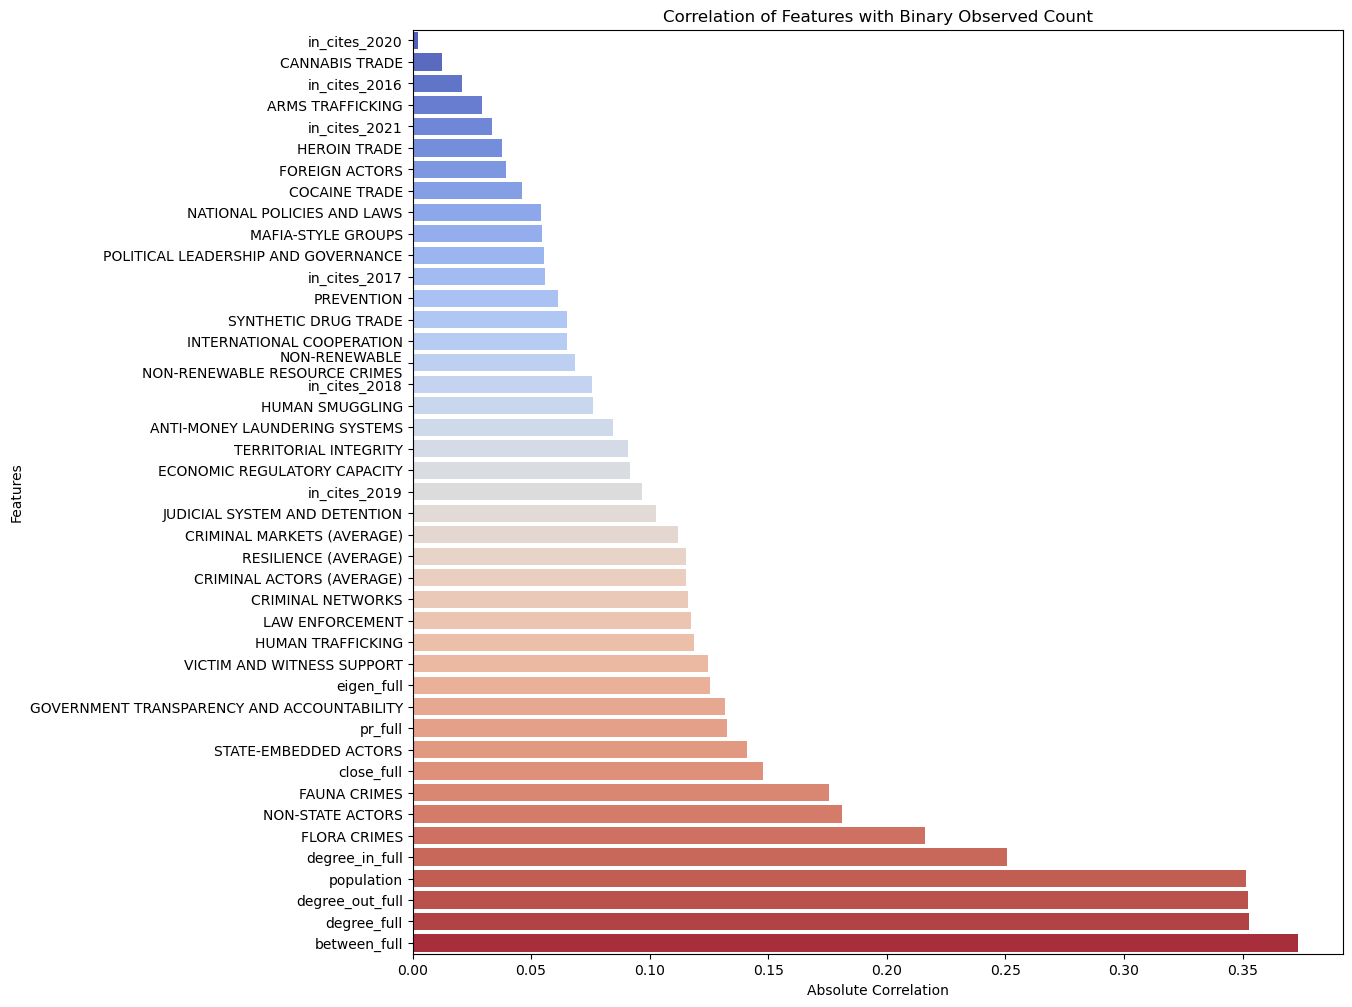

In [ ]:
node_df_new['binary_observed_count'] = (node_df_new['Observed_count'] > 0).astype(int)

# Compute correlation of each feature with the binary target variable 'binary_seizure_count'
target_correlation = node_df_new.iloc[:, 14:-4].corrwith(node_df_new['binary_observed_count'])
target_correlation = target_correlation.abs().sort_values(ascending=True)

plt.figure(figsize=(12, 12))
sns.barplot(x=target_correlation.values, y=target_correlation.index, palette='coolwarm')
plt.xlabel('Absolute Correlation')
plt.ylabel('Features')
plt.title("Correlation of Features with Binary Observed Count")
plt.show()

In [ ]:
# Replace the variable name below with each variable. Start from those with highest correlation with binary output and move downwards
# return items with a absolute value of correlation greater than 0.8
node_df_new.iloc[:, 15:-4].corrwith(node_df_new['in_cites_2020']).abs() > 0.8

MAFIA-STYLE GROUPS                              False
CRIMINAL NETWORKS                               False
STATE-EMBEDDED ACTORS                           False
FOREIGN ACTORS                                  False
CRIMINAL MARKETS (AVERAGE)                      False
HUMAN TRAFFICKING                               False
HUMAN SMUGGLING                                 False
ARMS TRAFFICKING                                False
FLORA CRIMES                                    False
FAUNA CRIMES                                    False
NON-RENEWABLE\nNON-RENEWABLE RESOURCE CRIMES    False
HEROIN TRADE                                    False
COCAINE TRADE                                   False
CANNABIS TRADE                                  False
SYNTHETIC DRUG TRADE                            False
RESILIENCE (AVERAGE)                            False
POLITICAL LEADERSHIP AND GOVERNANCE             False
GOVERNMENT TRANSPARENCY AND ACCOUNTABILITY      False
INTERNATIONAL COOPERATION   

### Visualize False Predictions from Model

In [ ]:
false_pos_neg = pd.read_excel('false_positives_and_negatives.xlsx')

In [ ]:
def extract_confidence(row):
    probabilities = row['probabilities']
    if row['label'] == 'false_positive':
        confidence = probabilities.rsplit(' ', 5)[1:]
    elif row['label'] == 'false_negative':
        confidence = probabilities.split(' ', 5)[:-1]
    confidence_str = ' '.join(confidence).strip('[]')
    return float(confidence_str)

# Apply the function to each row and create the new 'confidence' column
false_pos_neg['confidence'] = false_pos_neg.apply(extract_confidence, axis=1)

false_pos_neg

,Unnamed: 0,IATA,id,name,city,country,ICAO,latitude,longitude,altitude,...,incident_counts,binary_incident_observed,binary_origin_observed,binary_destination_observed,binary_transit_observed,label,probabilities,predicted_class,true_class,confidence
0,1,KZN,2990,Kazan International Airport,Kazan,russia,UWKD,55.606201,49.278702,411,...,0,0,0,0,0,false_positive,[0.45 0.55],1,0,0.550000
1,2,ASF,2966,Astrakhan Airport,Astrakhan,russia,URWA,46.283298,48.006302,-65,...,0,0,0,0,0,false_positive,[0.42 0.58],1,0,0.580000
2,10,KGD,2952,Khrabrovo Airport,Kaliningrad,russia,UMKK,54.889999,20.592600,42,...,0,0,0,0,0,false_positive,[0.49 0.51],1,0,0.510000
3,12,LED,2948,Pulkovo Airport,St. Petersburg,russia,ULLI,59.800301,30.262501,78,...,0,0,0,0,0,false_positive,[0.18 0.82],1,0,0.820000
4,13,SVX,2975,Koltsovo Airport,Yekaterinburg,russia,USSS,56.743099,60.802700,764,...,0,0,0,0,0,false_positive,[0.17 0.83],1,0,0.830000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349,1684,POL,985,Pemba Airport,Pemba,mozambique,FQPB,-12.991762,40.524014,331,...,1,1,1,0,0,false_negative,[0.86 0.14],0,1,0.860000
350,1710,KAN,270,Mallam Aminu International Airport,Kano,nigeria,DNKN,12.047600,8.524620,1562,...,1,1,1,0,0,false_negative,[0.535 0.465],0,1,0.535000
351,1796,RMI,1546,Federico Fellini International Airport,Rimini,italy,LIPR,44.020302,12.611700,40,...,2,1,0,1,0,false_negative,[0.95666667 0.04333333],0,1,0.956667
352,1798,AQJ,2172,Aqaba King Hussein International Airport,Aqaba,jordan,OJAQ,29.611601,35.018101,175,...,1,1,0,1,0,false_negative,[0.804 0.196],0,1,0.804000


/var/folders/px/g1w30xmx4gq5qw1_pnfzn1n40000gn/T/ipykernel_50681/1385516411.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Reds')


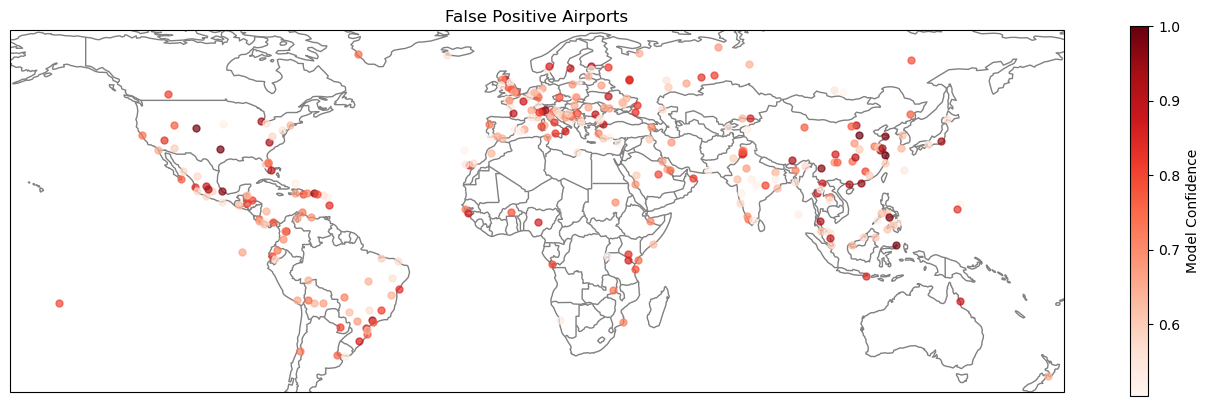

In [ ]:
scaling_factor = 100
fig, ax = plt.subplots(figsize = (17,12),subplot_kw={'projection': ccrs.PlateCarree()})
ax.add_feature(BORDERS, edgecolor='gray')
ax.add_feature(COASTLINE, edgecolor='gray')

# for _, row in false_pos_neg.iterrows():
#     if row['label'] == 'false_positive':
#         iata = row['IATA']
#         lon, lat = row['longitude'], row['latitude']
#         color = 'red' if row['label'] == 'false_positive' else 'blue'
#         marker = 'o' if row['label'] == 'false_positive' else 'v'
#         ax.plot(lon, lat, marker=marker, color=color, markersize=5, alpha=0.5)
#     else:
#         continue


cmap = cm.get_cmap('Reds')
norm = mcolors.Normalize(vmin=false_pos_neg['confidence'].min(), vmax=false_pos_neg['confidence'].max())

for _, row in false_pos_neg.iterrows():
    if row['label'] == 'false_positive':
        iata = row['IATA']
        lon, lat = row['longitude'], row['latitude']
        confidence = row['confidence']
        color = cmap(norm(confidence))
        marker = 'o'
        ax.plot(lon, lat, marker=marker, color=color, markersize=5, alpha=0.7)
    else:
        continue

# Label the top 10 nodes on the map based on their confidence
# top_10 = false_pos_neg.nlargest(10, 'confidence')
# texts = []
# for _, row in top_10.iterrows():
#     lon, lat = row['longitude'], row['latitude']
#     texts.append(ax.text(lon, lat, row['IATA'], fontsize=12, color='black'))
# adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray', lw=0.5))

# Add size legend
# sizes = [0.90,0.75,0.50]
# for size in sizes:
#     ax.plot([], [], 'ro', markersize=size*7, alpha = 0.5, label=str(size))
# ax.legend(scatterpoints=1, frameon=False, labelspacing=1, loc='lower left', title="Confidence")

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', shrink = 0.4)
cbar.set_label('Model Confidence')

ax.set_title("False Positive Airports")
plt.show()